In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 12 12:13:00 2022

@author: Bradley

Data Analysis for Shared Bikes and Didi Cars
"""

'\nCreated on Thu Feb 12 12:13:00 2022\n\n@author: Bradley\n\nData Analysis for Shared Bikes and Didi Cars\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

In [2]:
# decode the hashing location value
import geohash
# visualize heatmap
import folium
from folium.plugins import HeatMap

### **Shared Bikes Data Analysis and Visualization**

In [6]:
# 分析使用摩拜单车的公开的数据集，仅仅包含了两周左右骑行数据信息就已经100多M；另外是滴滴一个月的出行数据集，大小类似
# 100多M的数据集，属于kaggle竞赛常见的数据量，这个时候就要极度考虑代码运行的速度了，如何加速代码，减少模型训练时间等等
df = pd.read_csv('./raw_data/mobike.csv', parse_dates=['starttime']) # 起始时间转为时间戳
df.head()

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc,geohashed_end_loc
0,1893973,451147,210617,2,2017-05-14 22:16:50,wx4snhx,wx4snhj
1,4657992,1061133,465394,1,2017-05-14 22:16:52,wx4dr59,wx4dquz
2,2965085,549189,310572,1,2017-05-14 22:16:51,wx4fgur,wx4fu5n
3,4548579,489720,456688,1,2017-05-14 22:16:51,wx4d5r5,wx4d5r4
4,3936364,467449,403224,1,2017-05-14 22:16:50,wx4g27p,wx4g266


In [7]:
# orderid订单号，userid用户号，bikeid车辆号，starttime骑行开始时间，后两列为哈希后的骑行起始和终点经纬度坐标
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214096 entries, 0 to 3214095
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   orderid              int64         
 1   userid               int64         
 2   bikeid               int64         
 3   biketype             int64         
 4   starttime            datetime64[ns]
 5   geohashed_start_loc  object        
 6   geohashed_end_loc    object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 171.7+ MB


In [8]:
df.shape
df['starttime'].min()
df['starttime'].max()

(3214096, 7)

Timestamp('2017-05-10 00:00:09')

Timestamp('2017-05-24 19:00:16')

In [9]:
# 看到最后一天的数据并不完整，删除5月24号的数据
df = df.loc[df['starttime'] < '2017-05-24 00:00:00', :]
print(df.shape)

(3085688, 7)


In [10]:
# 查看numerical列的数据unique的数目，发现一共两种车型，34万个用户，48万个bike
df.userid.unique().size
df.bikeid.unique().size
df.biketype.unique().size

348066

481757

2

#### 空间数据处理

- 数据集中，起点和终点的信息被加密成了GeoHash。GeoHash将二维的经纬度转换成字符串，每一个字符串代表了某一矩形区域。这个矩形区域内所有的点（经纬度坐标）都共享相同的GeoHash字符串，这样既可以保护隐私（只表示大概区域位置而不是具体的点），又比较容易做地理位置相关的数据查询。
- Geohash能够提供任意经度的分段级别，一般分为1-12级。Geohash编码字符串越长，表示的区域范围越精确。
![](./image/fig.png)
- 这个数据集中GeoHash区块位置信息全部为7位GeoHash编码。按照对应的精度级别，每个区块在153米×153米范围内。

In [11]:
# 数据集里面的精度是153m左右的，对于共享单车，显然不够。很可能在路边寻找共享单车，但定位的范围太大以至于到了一个小区。
# 所以需要先decode然后获取更高的精度。但注意实际上hash编码的本质就是为了保护数据，而hash编码的位数决定了原始坐标经纬度数据在hash的过程中丢失信息的大小，所以decode是不能复原这部分已经丢失的信息的

# 解码示例
df['geohashed_start_loc'][0]
geohash.decode(df['geohashed_start_loc'][0])

'wx4snhx'

(40.10353088378906, 116.28959655761719)

In [12]:
# 定义纬度和经度解码函数，使用apply进行解码
def geohash_decode_lat(loc):
    return geohash.decode(loc)[0]

def geohash_decode_lng(loc):
    return geohash.decode(loc)[1]

df['start_lat'] = df['geohashed_start_loc'].apply(geohash_decode_lat) #开始位置纬度
df['start_lng'] = df['geohashed_start_loc'].apply(geohash_decode_lng) #开始位置经度

df['end_lat'] = df['geohashed_end_loc'].apply(geohash_decode_lat) #结束位置纬度
df['end_lng'] = df['geohashed_end_loc'].apply(geohash_decode_lng) #结束位置经度

In [14]:
# 根据haversine公式计算两个经纬度对应的坐标点在地球表面的距离，来近似表示骑行的远近：
# 其实不是那么的科学，但是因为没有gps记录车辆运行的路径，所以只能通过这种方式计算直线距离作为估计

from math import radians, cos, sin, asin, sqrt

# 计算球面两点间的距离
def haversine(lon1, lat1, lon2, lat2):
    # 转换为极坐标
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    return c * r * 1000  # 返回单位为米

# 计算起点终点直线距离
df['start_end_distance'] = df.apply(lambda s : haversine(s['start_lng'], s['start_lat'], s['end_lng'], s['end_lat']), axis = 1)

In [13]:
df.head()

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc,geohashed_end_loc,start_lat,start_lng,end_lat,end_lng
0,1893973,451147,210617,2,2017-05-14 22:16:50,wx4snhx,wx4snhj,40.103531,116.289597,40.100784,116.286850
1,4657992,1061133,465394,1,2017-05-14 22:16:52,wx4dr59,wx4dquz,39.790421,116.325302,39.797287,116.322556
2,2965085,549189,310572,1,2017-05-14 22:16:51,wx4fgur,wx4fu5n,39.882431,116.542282,39.875565,116.551895
3,4548579,489720,456688,1,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,39.765701,116.163254,39.765701,116.161880
4,3936364,467449,403224,1,2017-05-14 22:16:50,wx4g27p,wx4g266,39.963455,116.388474,39.959335,116.381607


#### 时间数据处理

In [15]:
# 由于给到的时间戳是完整的格式，可以从中获取小时，day，还有在一周中属于星期几的信息，然后分别进行分析
df["day"] = df["starttime"].apply(lambda s:str(s)[:10]) #提取时间中的日期
df["hour"] = df["starttime"].apply(lambda s: s.hour) #提取小时数，hour属性
df["weekday"] = df["starttime"].apply(lambda s: s.weekday()) #使用weekday函数提取周几信息，周一为0，周日为6，datetime的.weekday函数
df.head()

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc,geohashed_end_loc,start_lat,start_lng,end_lat,end_lng,start_end_distance,day,hour,weekday
0,1893973,451147,210617,2,2017-05-14 22:16:50,wx4snhx,wx4snhj,40.103531,116.289597,40.100784,116.286850,384.504518,2017-05-14,22,6
1,4657992,1061133,465394,1,2017-05-14 22:16:52,wx4dr59,wx4dquz,39.790421,116.325302,39.797287,116.322556,798.761617,2017-05-14,22,6
2,2965085,549189,310572,1,2017-05-14 22:16:51,wx4fgur,wx4fu5n,39.882431,116.542282,39.875565,116.551895,1120.638699,2017-05-14,22,6
3,4548579,489720,456688,1,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,39.765701,116.163254,39.765701,116.161880,117.377687,2017-05-14,22,6
4,3936364,467449,403224,1,2017-05-14 22:16:50,wx4g27p,wx4g266,39.963455,116.388474,39.959335,116.381607,743.197624,2017-05-14,22,6


#### 融入天气数据信息

In [16]:
df_weather = pd.read_csv('./raw_data/mobike_weather.csv')
df_weather.head(10)

,day,temperature_high,temperature_low,weather,wind_direction,wind_level
0,2017-05-10,30,15,晴,西南风,4
1,2017-05-11,31,12,晴,北风,6
2,2017-05-12,29,15,多云,西北风,3
3,2017-05-13,27,15,晴,西风,3
4,2017-05-14,27,14,多云,南风,3
5,2017-05-15,28,15,晴,西南风,4
6,2017-05-16,32,17,多云,西南风,5
7,2017-05-17,34,19,晴,南风,2
8,2017-05-18,35,21,晴,西南风,3
9,2017-05-19,36,22,多云,西南风,5


In [17]:
df_weather.shape

(14, 6)

In [18]:
# 因为天气数据范围更广，需要依据day这一列进行merge，注意day在两个dataframe中都不能为index
df_combined = pd.merge(df, df_weather, on='day')
df_combined.shape
df_combined.head(6)

(3085688, 20)

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc,geohashed_end_loc,start_lat,start_lng,end_lat,end_lng,start_end_distance,day,hour,weekday,temperature_high,temperature_low,weather,wind_direction,wind_level
0,1893973,451147,210617,2,2017-05-14 22:16:50,wx4snhx,wx4snhj,40.103531,116.289597,40.100784,116.286850,384.504518,2017-05-14,22,6,27,14,多云,南风,3
1,4657992,1061133,465394,1,2017-05-14 22:16:52,wx4dr59,wx4dquz,39.790421,116.325302,39.797287,116.322556,798.761617,2017-05-14,22,6,27,14,多云,南风,3
2,2965085,549189,310572,1,2017-05-14 22:16:51,wx4fgur,wx4fu5n,39.882431,116.542282,39.875565,116.551895,1120.638699,2017-05-14,22,6,27,14,多云,南风,3
3,4548579,489720,456688,1,2017-05-14 22:16:51,wx4d5r5,wx4d5r4,39.765701,116.163254,39.765701,116.161880,117.377687,2017-05-14,22,6,27,14,多云,南风,3
4,3936364,467449,403224,1,2017-05-14 22:16:50,wx4g27p,wx4g266,39.963455,116.388474,39.959335,116.381607,743.197624,2017-05-14,22,6,27,14,多云,南风,3
5,5163705,917620,509044,1,2017-05-14 22:16:53,wx4gd2e,wx4g6pw,39.993668,116.470871,39.988174,116.464005,845.738929,2017-05-14,22,6,27,14,多云,南风,3


#### 数据分析

时间特征分析：基本思路是对不同的时间特征进行groupby然后分析绘图

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='day', ylabel='orderid'>

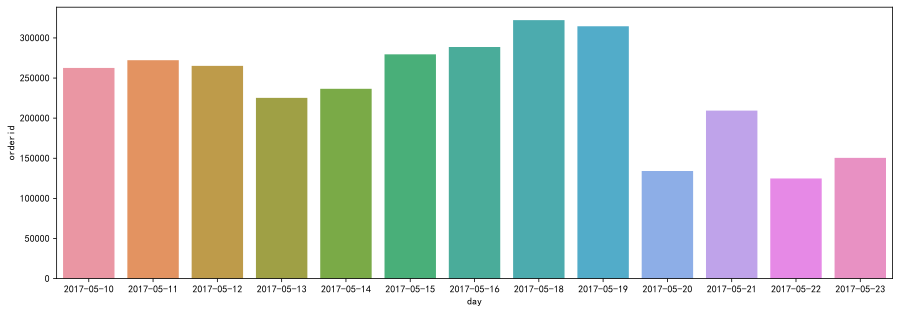

In [20]:
# 不同天数的订单数情况分析
day_group = df_combined.groupby('day')
day_num_df = day_group.agg({'orderid': 'count'}).reset_index() #reset_index不然seaborn没法找到day这一列
plt.figure(figsize=(15, 5))
sns.barplot(x='day', y='orderid', data=day_num_df)
plt.savefig("./figures/day_order_histogram.png", dpi=600)

# 分析得出：数据集的数据中，5月20日后的骑行订单数明显减小，可能与摩拜当时采取的促销等市场营销策略有关。促销活动到期之类的因素有关。

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='orderid'>

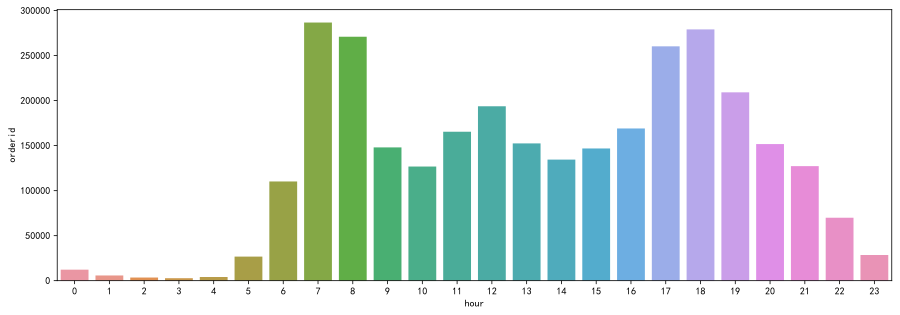

In [22]:
# 平均下来不同小时的订单数量分析
hour_group = df_combined.groupby('hour')
hour_num_df = hour_group.agg({'orderid': 'count'}).reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='hour', y='orderid', data=hour_num_df)
plt.savefig("./figures/hour_order_histogram.png", dpi=600)

# 分析得出：凌晨5点之前几乎没有人骑车出行；早晨7-9点是早高峰，晚上17-19点是晚高峰，特征明显；中午午餐时段也有一个小高峰

In [25]:
# 由于早晚高峰会收到工作日的影响，下比较工作日和周末的不同的出行特征

# 如果weekday是5或者6，则为周末（记为1，反之记为0）
# 当然这里考虑的比较简单，没有考虑节假日的情况，也可以回看日期5月那个时候没有节假日，一会滴滴的分析过程会考虑节假日
df_combined.loc[(df_combined["weekday"] == 5) | (df_combined["weekday"] == 6), "isWeekend"] = 1
df_combined.loc[~((df_combined["weekday"] == 5) | (df_combined["weekday"] == 6)), "isWeekend"] = 0

# 查看数据集中工作日和周末分别的数据量，一共是4个周末和9个工作日
print(df_combined[df_combined["isWeekend"] == 1]["day"].unique().size)
print(df_combined[df_combined["isWeekend"] == 0]["day"].unique().size)

4
9


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='orderid'>

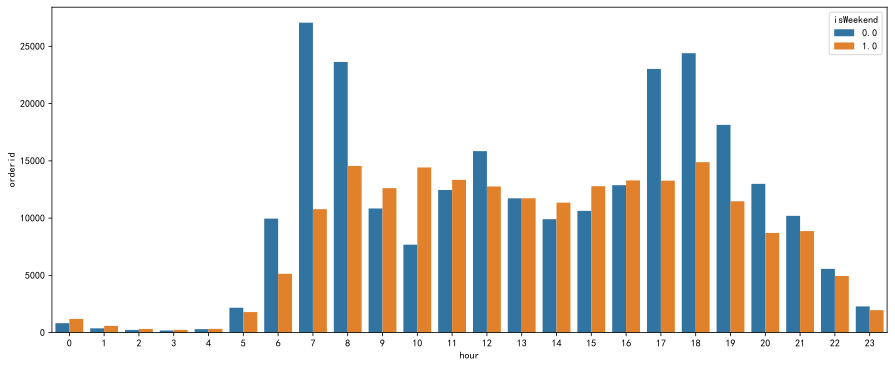

In [26]:
# 计算工作日与非工作日的每日的不同小时的平均订单量，查看随时间变化的订单量分布情况
weekend_num = df_combined[df_combined["isWeekend"] == 1]["day"].unique().size
weekday_num = df_combined[df_combined["isWeekend"] == 0]["day"].unique().size

hour_group = df_combined.groupby(["isWeekend", "hour"])
# 创建一个副本分析
hour_num_df = pd.DataFrame(hour_group['orderid'].count()).reset_index()
# 算了平均才具有可比性
hour_num_df.loc[hour_num_df['isWeekend'] == 0.0, 'orderid'] = hour_num_df['orderid'] / weekday_num
hour_num_df.loc[hour_num_df['isWeekend'] == 1.0, 'orderid'] = hour_num_df['orderid'] / weekend_num
plt.figure(figsize=(15, 6))
# 指明hue参数即一列的categorical变量可以实现compare型的bar chart    
sns.barplot(x='hour', y="orderid", hue="isWeekend", data=hour_num_df)
plt.savefig("./figures/workday_compare.png", dpi=600) 

# 分析得出：确实是工作日的早晚高峰更加明显（反映了摩拜单车作为通勤工具的使用），而周末的骑行订单则在白天的分布比较均匀

In [27]:
# 由于数据只有十几天，天气比较平均，没有极端天气，大多数都是晴天或者多云，因此可能以风速为特征着重分析比较有意义
# 下比较不同风速下的骑行订单数的变化

# 查看有几个风速等级
wind_level_set = set(df_weather['wind_level'])
wind_level_set

{2, 3, 4, 5, 6}

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='orderid'>

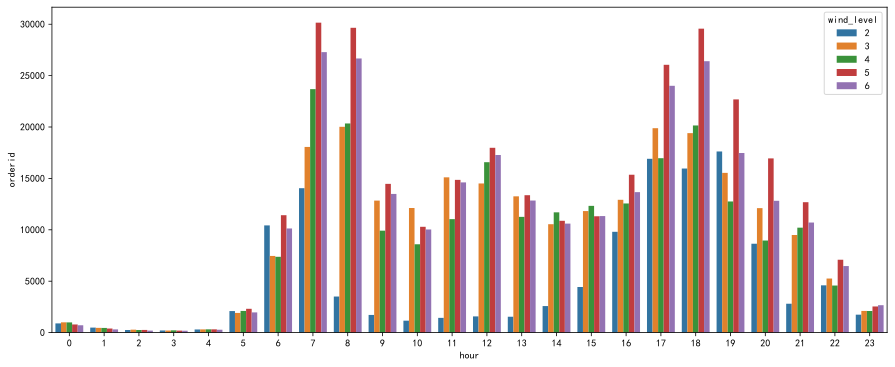

In [28]:
# 对五个风速等级分别画不同小时的订单平均值
hour_group = df_combined.groupby(["wind_level", "hour"])
hour_num_df = pd.DataFrame(hour_group['orderid'].count()).reset_index()

# 按照不同风速统计平均值
for wind_level in wind_level_set:
    wind_level_num = df_combined[df_combined["wind_level"] == wind_level]["day"].unique().size
    hour_num_df.loc[hour_num_df['wind_level'] == wind_level, 'orderid'] = hour_num_df['orderid'] / wind_level_num

plt.figure(figsize=(15, 6))
sns.barplot(x='hour', y="orderid", hue="wind_level", data=hour_num_df)

plt.savefig("./figures/wind_effect.png", dpi=600) 

# 分析得出：数据量的缘故，这里的结果并不是很明显，订单的数量并没有随着风速的增加而有明显的下降。我们期待是看到风速越大订单量下降越明显的，但这里没看出strong evidence

空间/地理特征分析

In [29]:
# 查看骑行距离的分位数统计量
df_combined["start_end_distance"].describe()

# 用户骑行距离的平均值815米，中位数660米，75%在949米。这几个数据反映了用户一般为近距离骑行，比较合理
# 最大距离值达到44900米，有可能是异常值

count    3.085688e+06
mean     8.142945e+02
std      6.860875e+02
min      1.163695e+02
25%      4.654694e+02
50%      6.603597e+02
75%      9.496259e+02
max      4.490018e+04
Name: start_end_distance, dtype: float64

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='start_end_distance', ylabel='Density'>

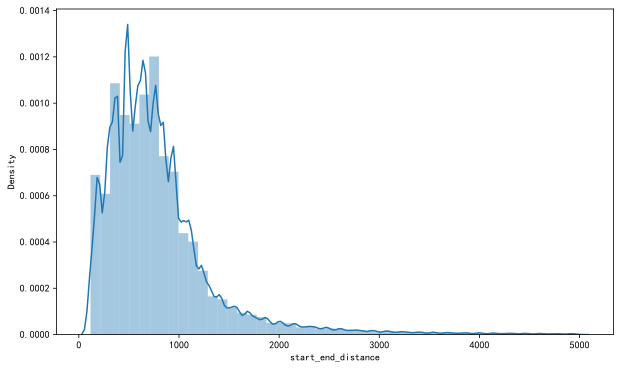

In [34]:
# 剔除超过5千米的骑行距离，把剩下的距离数据的分布画出来
plt.figure(figsize=(10, 6))
start_end_distance = df_combined["start_end_distance"]
start_end_distance = start_end_distance.loc[start_end_distance < 5000]

sns.set_color_codes()
sns.distplot(start_end_distance)

plt.savefig("./figures/distance.png", dpi=300) 

# 分析：可见大多数用户的骑行距离还是在1000米之内的

In [35]:
# 查看不同的车型会不会影响用户骑行距离

g_biketype = df_combined.groupby("biketype")
g_biketype.agg({"start_end_distance": "mean"})

# 可以看到两种车型的平均骑行距离差不多，2代车型的数值稍大一些

,start_end_distance
biketype,
1,808.000130
2,823.960257


In [36]:
# 看不同的天气因素对于骑行距离的影响，这里我们仅以最高温和最低温举例
g_biketype = df_combined.groupby("temperature_high")
g_biketype.agg({"start_end_distance": "mean"})

g_biketype = df_combined.groupby("temperature_low")
g_biketype.agg({"start_end_distance": "mean"})

# 没有发现明显的随着温度变化的规律

,start_end_distance
temperature_high,
18,836.961002
27,793.174493
28,839.884606
29,858.597367
30,883.467487
31,791.318973
32,851.979265
35,763.710928
36,780.214107


,start_end_distance
temperature_low,
12,845.214667
13,836.961002
14,798.822760
15,850.270646
17,851.979265
18,721.270525
20,725.468483
21,779.634429
22,780.214107


<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='start_end_distance'>

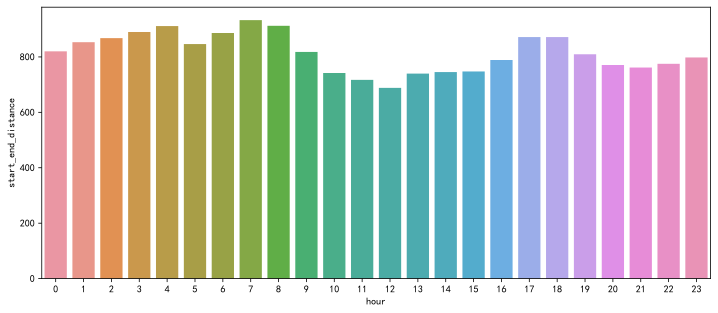

In [38]:
# 看不同的时间段是否会影响用户的骑行距离
hour_group = df_combined.groupby("hour")
hour_distance = hour_group.agg({"start_end_distance": "mean"}).reset_index()
plt.figure(figsize=(12, 5))
sns.barplot(x='hour', y='start_end_distance', data=hour_distance)
plt.savefig("./figures/time_distance_compared.png", dpi=600) 

# 分析结果：可以看到不同时间段对用户的骑行距离影响也不大。中午少一点可能是骑车用户中午出去找吃的所以骑行举例比较短，而早晚高峰由于距离比较远所以会骑行更远的举例

<Figure size 432x360 with 0 Axes>

<AxesSubplot:xlabel='weather', ylabel='start_end_distance'>

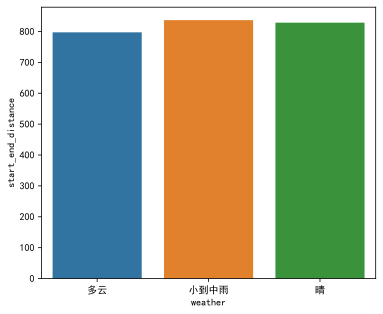

In [39]:
# 看不同的天气是否会影响用户的骑行距离

hour_group = df_combined.groupby("weather")
hour_distance = hour_group.agg({"start_end_distance": "mean"}).reset_index()
plt.figure(figsize=(6, 5))

sns.barplot(x='weather', y='start_end_distance', data=hour_distance)

plt.savefig("./figures/weather_distance_compared.png", dpi=600) 

# 在这个数据集中，下雨的情况下骑行的平均距离没有明显变小。反而增长了一点…绝了，分析了个寂寞

<Figure size 576x360 with 0 Axes>

<AxesSubplot:xlabel='wind_level', ylabel='start_end_distance'>

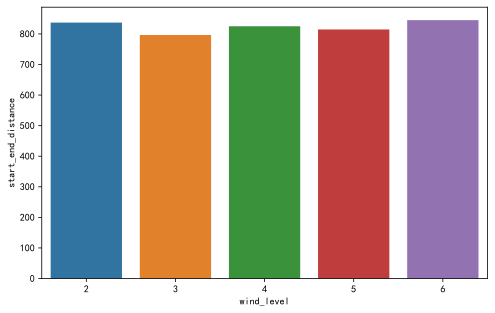

In [40]:
# 查看风速是否会影响用户的骑行距离

hour_group = df_combined.groupby("wind_level")
hour_distance = hour_group.agg({"start_end_distance": "mean"}).reset_index()
plt.figure(figsize=(8, 5))

sns.barplot(x='wind_level', y='start_end_distance', data=hour_distance)
plt.savefig("./figures/wind_distance_compared.png", dpi=600) 

# 类似的，这里的风速也没有很大的影响

起点终点地理位置分布热力图

In [ ]:
# 准确来说，这虽然是热力图的样式，但不属于热力图。正常的热力图是横纵坐标两个指标，然后热力值为对应参数下的某个指标值。
# 但这里不属于heatmap，所以我们也没有用seaborn的heatmap去画，因为这实际上还是一个直方图，还是一个histgram，只不过是二维的，而碰巧二维的histogram和heatmap很像。
# 具体来说，使用的是hist2d的函数，而且不用指标值，只用横纵坐标，这里横纵坐标分别是一系列连续型的经度维度值，然后对应那个点的颜色深浅就是对应横纵坐标下的frequency，而不是什么新的指标值。如果有一个小范围内的经度纬度矩形内有大量的数据点，那么对应的颜色就会很深。

# 这里由于数据点太多，全部范围画到热力图需要很大的计算量，内存和时间
# bins参数设置横纵坐标范围
plt.figure(figsize=(12, 8))
plt.hist2d(df_combined['start_lng'], df_combined['start_lat'],
           bins=[np.arange(min(df_combined['start_lng']),max(df_combined['start_lng']), 0.005),
                 np.arange(min(df_combined['start_lat']),max(df_combined['start_lat']), 0.005)])
plt.colorbar()
plt.show()

# 分析：由于经度维度范围太广，heatmap色块区分的不是很明显。因为横纵坐标范围太广了，而图片的size又很小，所以每个小区域都有比较集中的数据点，导致frequency差不多

<Figure size 864x576 with 0 Axes>

(array([[1743.,  217.,   64., ...,    0.,    0.,    0.],
        [ 238.,  196.,   15., ...,    0.,    0.,   16.],
        [ 162.,   54.,  207., ...,    0.,   20.,   64.],
        ...,
        [ 129.,  493., 2926., ...,    3.,   19.,    0.],
        [ 537.,  794.,  747., ...,   18.,   10.,    0.],
        [2222.,  328.,  148., ...,  197.,    6.,    7.]]),
 array([116.21 , 116.215, 116.22 , 116.225, 116.23 , 116.235, 116.24 ,
        116.245, 116.25 , 116.255, 116.26 , 116.265, 116.27 , 116.275,
        116.28 , 116.285, 116.29 , 116.295, 116.3  , 116.305, 116.31 ,
        116.315, 116.32 , 116.325, 116.33 , 116.335, 116.34 , 116.345,
        116.35 , 116.355, 116.36 , 116.365, 116.37 , 116.375, 116.38 ,
        116.385, 116.39 , 116.395, 116.4  , 116.405, 116.41 , 116.415,
        116.42 , 116.425, 116.43 , 116.435, 116.44 , 116.445, 116.45 ,
        116.455, 116.46 , 116.465, 116.47 , 116.475, 116.48 , 116.485,
        116.49 , 116.495, 116.5  , 116.505, 116.51 , 116.515, 116.52 ,
    

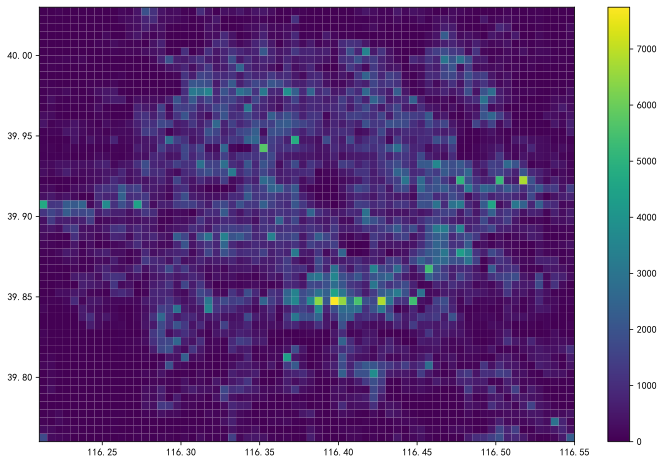

In [48]:
# 减小横纵坐标范围，再次画图。这里对应的范围大致对应北京的五环路内
plt.figure(figsize=(12, 8))
plt.hist2d(df_combined['start_lng'], df_combined['start_lat'],
           bins=[np.arange(116.21, 116.55, 0.005),
                 np.arange(39.76, 40.03, 0.005)])
plt.colorbar()
plt.savefig("./figures/heatmap_start.png", dpi=600) 
plt.show()

<Figure size 864x576 with 0 Axes>

(array([[1.460e+03, 2.000e+02, 4.800e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.220e+02, 6.600e+01, 1.200e+01, ..., 0.000e+00, 1.000e+00,
         5.000e+01],
        [1.950e+02, 4.500e+01, 1.500e+02, ..., 0.000e+00, 3.500e+01,
         5.100e+01],
        ...,
        [2.090e+02, 6.750e+02, 3.433e+03, ..., 7.000e+00, 1.300e+01,
         1.000e+00],
        [3.770e+02, 9.280e+02, 8.210e+02, ..., 2.300e+01, 5.000e+00,
         0.000e+00],
        [1.659e+03, 4.160e+02, 8.900e+01, ..., 1.070e+02, 5.000e+00,
         1.000e+01]]),
 array([116.21 , 116.215, 116.22 , 116.225, 116.23 , 116.235, 116.24 ,
        116.245, 116.25 , 116.255, 116.26 , 116.265, 116.27 , 116.275,
        116.28 , 116.285, 116.29 , 116.295, 116.3  , 116.305, 116.31 ,
        116.315, 116.32 , 116.325, 116.33 , 116.335, 116.34 , 116.345,
        116.35 , 116.355, 116.36 , 116.365, 116.37 , 116.375, 116.38 ,
        116.385, 116.39 , 116.395, 116.4  , 116.405, 116.41 , 116.415,
        116.42 , 11

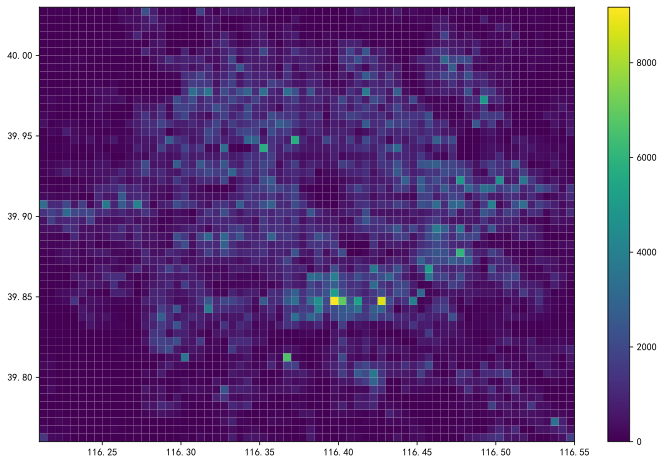

In [49]:
# 类似的，画终点的热力图
plt.figure(figsize=(12, 8))
plt.hist2d(df_combined['end_lng'], df_combined['end_lat'],
           bins=[np.arange(116.21, 116.55, 0.005),
                 np.arange(39.76, 40.03, 0.005)])
plt.colorbar()
plt.savefig("./figures/heatmap_end.png", dpi=600) 
plt.show()

In [51]:
# 由于订单总数太多，全部渲染到地图上计算量太大，我们在这里随机采样10000个数据点绘制热力图
# 这也是无奈之举，仅仅14天的数据，三百多万条，前面如果不是限制了经度维度的范围，那个热力图好几分钟也跑不出来

# 使用专业可视化工具folium实现地图的热力图渲染
start_points = []
start_lng = df_combined['start_lng']
start_lat = df_combined['start_lat']
# 每一个point为（纬度、经度、权重），这里每个点权重都设为1
# permutation任取排列，相当于打乱
start_points = [[i[1], i[0], 1] for i in np.random.permutation(list(zip(start_lng, start_lat)))[:10000]] 

end_points = []
end_lng = df['end_lng']
end_lat = df['end_lat']
# 每一个point为（纬度、经度、权重），这里每个点权重都设为1
end_points = [[i[1], i[0], 1] for i in np.random.permutation(list(zip(end_lng, end_lat)))[:10000]]

len(start_points)
len(end_points)

10000

10000

In [54]:
# 使用高德地图作为底层地图逻辑，可以更改配色方案

# 画起点热力图
map_start = folium.Map(location=[(39.76 + 40.03)/2, (116.21 + 116.55) / 2],  # 设置地图显示的中心点
                       zoom_start=12,  # 地图默认加载时的缩放等级
                       tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=7&x={x}&y={y}&z={z}',
                       attr='default') #设置地图模式为高德地图，看官方文档可以查看其他的


# 热力图的方式叠加到地图的对象上，实现gps点的绘制
HeatMap(start_points).add_to(map_start)

map_start.save("./output/mobike_start_heatmap.html")


In [53]:
# 画终点热力图
map_end = folium.Map(location=[(39.76 + 40.03)/2, (116.21 + 116.55) / 2],  # 设置地图显示的中心点
                     zoom_start=12,  # 地图默认加载时的缩放等级
                     tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=7&x={x}&y={y}&z={z}',
                     attr='default')

# 热力图的方式叠加到地图的对象上，实现gps点的绘制
HeatMap(end_points).add_to(map_end)

map_end.save("./output/mobike_end_heatmap.html")

可以自行打开html进行细节查看。打开html，可以看到热力图没有覆盖的区域，可能就是单车起点终点较少的地方，比如天安门广场，共享单车难以摆放，通行。还有玉渊潭公园等等，学校等等，共享单车没法cover的区域。

### **DIDI Cars Data Analysis and Visualization**

In [3]:
# 新增一列时间数据，订单结束的时间，滴滴师傅按行程结束的时间
df_didi = pd.read_csv('./raw_data/didi.csv', parse_dates=['departure_time', 'arrive_time'])
df_didi.head()

,order_id,departure_time,arrive_time,starting_lng,starting_lat,dest_lng,dest_lat
0,17592719043682,2017-05-19 01:05:19,2017-05-19 01:09:12,110.3665,20.0059,110.3645,20.0353
1,17592719302995,2017-05-19 02:04:38,2017-05-19 02:08:13,110.3361,20.0364,110.3337,20.0652
2,17592719330238,2017-05-19 02:33:07,2017-05-19 02:35:16,110.3333,20.0222,110.3401,20.0081
3,17592720943629,2017-05-19 07:47:21,2017-05-19 07:49:19,110.3002,19.9818,110.2842,20.0071
4,17592721794216,2017-05-19 08:10:58,2017-05-19 08:13:32,110.3157,20.0580,110.3265,20.0297


In [4]:
# orderid订单号，departure_time订单出发时间，arrive_time订单到达时间，starting_lng, starting_lat：起点的经纬度，dest_lng, dest_lat：终点的经纬度
# 别弄混了，departure_time是出发时间，arrive_time是到达时间
df_didi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548464 entries, 0 to 1548463
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   order_id        1548464 non-null  int64         
 1   departure_time  1548464 non-null  datetime64[ns]
 2   arrive_time     1548464 non-null  datetime64[ns]
 3   starting_lng    1548464 non-null  float64       
 4   starting_lat    1548464 non-null  float64       
 5   dest_lng        1548464 non-null  float64       
 6   dest_lat        1548464 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 82.7 MB


In [5]:
df_didi.shape
df_didi['departure_time'].min()
df_didi['departure_time'].max()

(1548464, 7)

Timestamp('2017-05-01 00:00:05')

Timestamp('2017-05-31 23:59:59')

In [6]:
# 估算订单行程距离
from math import radians, cos, sin, asin, sqrt
# 计算球面两点间的距离
def haversine(lon1, lat1, lon2, lat2):
    # 转换为极坐标
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # 地球平均半径，单位为公里
    return c * r * 1000  # 返回单位为米

df_didi['start_end_distance'] = df_didi.apply(lambda s : haversine(s['starting_lng'], s['starting_lat'], s['dest_lng'], s['dest_lat']), axis = 1)

In [7]:
# 时间数据处理
df_didi["day"] = df_didi["departure_time"].apply(lambda s:str(s)[:10])
df_didi["hour"] = df_didi["departure_time"].apply(lambda s: s.hour)
df_didi["weekday"] = df_didi["departure_time"].apply(lambda s: s.weekday()) #使用weekday函数提取周几信息，周一为0，周日为6

# 由于现在有了两个时间，可以计算订单时长
df_didi['duration'] = df_didi['arrive_time'] - df_didi['departure_time']

def duration_to_minutes(duration):
    return duration.seconds / 60

df_didi['duration_minutes'] = df_didi['duration'].apply(duration_to_minutes)

df_didi.head()

,order_id,departure_time,arrive_time,starting_lng,starting_lat,dest_lng,dest_lat,start_end_distance,day,hour,weekday,duration,duration_minutes
0,17592719043682,2017-05-19 01:05:19,2017-05-19 01:09:12,110.3665,20.0059,110.3645,20.0353,3275.801716,2017-05-19,1,4,0 days 00:03:53,3.883333
1,17592719302995,2017-05-19 02:04:38,2017-05-19 02:08:13,110.3361,20.0364,110.3337,20.0652,3212.211315,2017-05-19,2,4,0 days 00:03:35,3.583333
2,17592719330238,2017-05-19 02:33:07,2017-05-19 02:35:16,110.3333,20.0222,110.3401,20.0081,1721.307110,2017-05-19,2,4,0 days 00:02:09,2.150000
3,17592720943629,2017-05-19 07:47:21,2017-05-19 07:49:19,110.3002,19.9818,110.2842,20.0071,3272.532284,2017-05-19,7,4,0 days 00:01:58,1.966667
4,17592721794216,2017-05-19 08:10:58,2017-05-19 08:13:32,110.3157,20.0580,110.3265,20.0297,3342.935019,2017-05-19,8,4,0 days 00:02:34,2.566667


#### 数据分析

时间特征分析

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='day', ylabel='order_id'>

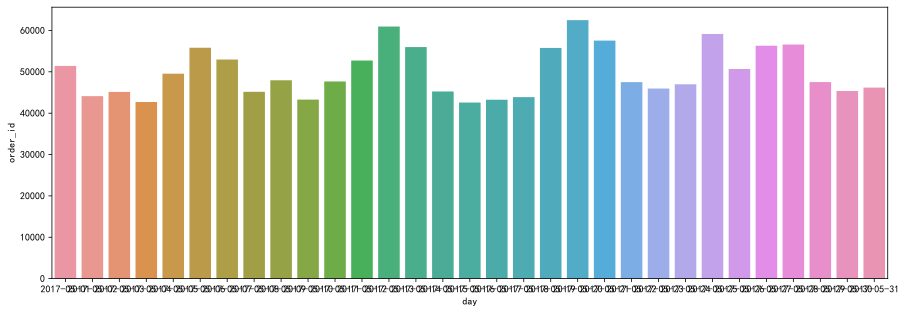

In [9]:
# 不同天数的订单量的情况
day_group = df_didi.groupby('day')
day_num_df = day_group.agg({'order_id': 'count'}).reset_index()
plt.figure(figsize=(15, 5))
sns.barplot(x='day', y='order_id', data=day_num_df)

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='order_id'>

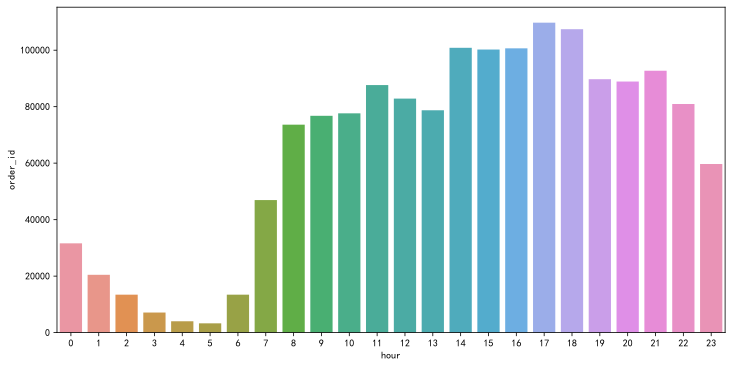

In [10]:
# 不同小时的平均出行量
hour_group = df_didi.groupby('hour')
hour_num_df = hour_group.agg({'order_id': 'count'}).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='order_id', data=hour_num_df)

# 分析：凌晨5点之前打车的人越来越少，后面逐渐增多；早晚高峰并不明显

In [11]:
# 查看工作日的情况，同时这里处理了节假日的信息

# 如果weekday是5或者6，则为周末（记为1，反之记为0）
df_didi.loc[(df_didi["weekday"] == 5) | (df_didi["weekday"] == 6), "isWeekend"] = 1
df_didi.loc[~((df_didi["weekday"] == 5) | (df_didi["weekday"] == 6)), "isWeekend"] = 0

# 首先是五一劳动节的调整，我们也归入周末
df_didi.loc[df_didi["day"] == '2017-05-01', "isWeekend"] = 1

# 其次是端午节的调休
# 5月27日周六上班
df_didi.loc[df_didi["day"] == '2017-05-27', "isWeekend"] = 0
# 5月28日至30日放假调休
df_didi.loc[df_didi["day"] == '2017-05-29', "isWeekend"] = 1
df_didi.loc[df_didi["day"] == '2017-05-30', "isWeekend"] = 1

# 可以计算，该数据集中一共有10个周末和21个工作日
print(df_didi[df_didi["isWeekend"] == 1]["day"].unique().size)
print(df_didi[df_didi["isWeekend"] == 0]["day"].unique().size)

10
21


<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='order_id'>

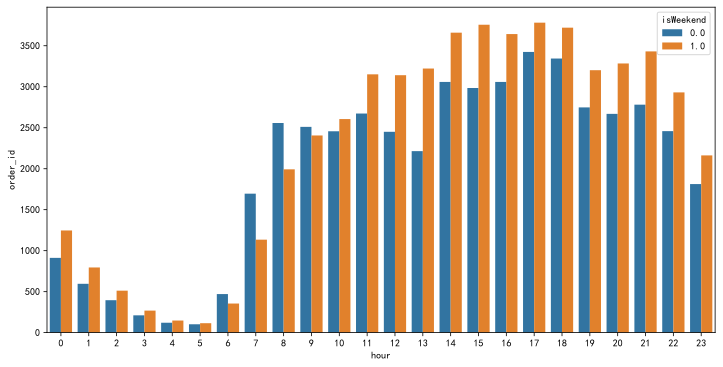

In [12]:
# 计算出工作日、非工作日每个小时的平均订单量，查看随时间变化的订单量分布情况
weekend_num = df_didi[df_didi["isWeekend"] == 1]["day"].unique().size
weekday_num = df_didi[df_didi["isWeekend"] == 0]["day"].unique().size

hour_group = df_didi.groupby(["isWeekend", "hour"])
hour_num_df = pd.DataFrame(hour_group['order_id'].count()).reset_index()
hour_num_df.loc[hour_num_df['isWeekend'] == 0.0, 'order_id'] = hour_num_df['order_id'] / weekday_num
hour_num_df.loc[hour_num_df['isWeekend'] == 1.0, 'order_id'] = hour_num_df['order_id'] / weekend_num
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y="order_id", hue="isWeekend", data=hour_num_df)

# 分析：可以看到滴滴快车并没有明显的早晚高峰出行特征，而周末的订单数更多，可能反映了滴滴快车更多地作为周末娱乐出行的交通工具

In [15]:
# 加入天气因素
df_didi_weather = pd.read_csv('./raw_data/didi_weather.csv')
df_didi_weather.head()
df_didi_weather.shape

# 很好，此时数据的跨度比较长，有一个月，里面有一些极端的天气，可以针对该字段进行进一步的分析

,day,temperature_high,temperature_low,weather,wind_direction,wind_level
0,2017-05-01,32,25,多云,东南风,5
1,2017-05-02,34,25,多云,西南风,2
2,2017-05-03,36,26,多云,东南风,5
3,2017-05-04,32,25,大到暴雨,东北风,4
4,2017-05-05,30,24,雷阵雨,东风,2


(31, 6)

In [17]:
# 合并dataset
df_didi_combined = pd.merge(df_didi, df_didi_weather, on='day')
df_didi_combined.head()

,order_id,departure_time,arrive_time,starting_lng,starting_lat,dest_lng,dest_lat,start_end_distance,day,hour,weekday,duration,duration_minutes,isWeekend,temperature_high,temperature_low,weather,wind_direction,wind_level
0,17592719043682,2017-05-19 01:05:19,2017-05-19 01:09:12,110.3665,20.0059,110.3645,20.0353,3275.801716,2017-05-19,1,4,0 days 00:03:53,3.883333,0.0,29,24,雷阵雨,东风,4
1,17592719302995,2017-05-19 02:04:38,2017-05-19 02:08:13,110.3361,20.0364,110.3337,20.0652,3212.211315,2017-05-19,2,4,0 days 00:03:35,3.583333,0.0,29,24,雷阵雨,东风,4
2,17592719330238,2017-05-19 02:33:07,2017-05-19 02:35:16,110.3333,20.0222,110.3401,20.0081,1721.307110,2017-05-19,2,4,0 days 00:02:09,2.150000,0.0,29,24,雷阵雨,东风,4
3,17592720943629,2017-05-19 07:47:21,2017-05-19 07:49:19,110.3002,19.9818,110.2842,20.0071,3272.532284,2017-05-19,7,4,0 days 00:01:58,1.966667,0.0,29,24,雷阵雨,东风,4
4,17592721794216,2017-05-19 08:10:58,2017-05-19 08:13:32,110.3157,20.0580,110.3265,20.0297,3342.935019,2017-05-19,8,4,0 days 00:02:34,2.566667,0.0,29,24,雷阵雨,东风,4


In [18]:
# 查看天气的不同种类
weather_level_set = set(df_didi_weather['weather'])
weather_level_set

{'多云', '大到暴雨', '大雨', '阵雨', '雷阵雨'}

<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='order_id'>

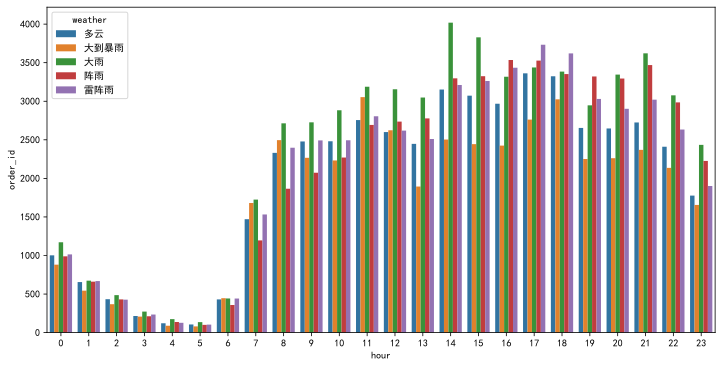

In [20]:
# 根据不同天气查看订单数目
hour_group = df_didi_combined.groupby(["weather", "hour"])
hour_num_df = pd.DataFrame(hour_group['order_id'].count()).reset_index()

# 按照不同天气统计平均值
for weather in weather_level_set:
    weather_level_num = df_didi_combined[df_didi_combined["weather"] == weather]["day"].unique().size
    hour_num_df.loc[hour_num_df['weather'] == weather, 'order_id'] = hour_num_df['order_id'] / weather_level_num

# 绘图
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y="order_id", hue="weather", data=hour_num_df)

# 分析：可以看出下雨天气对于订单数的影响可能是两方面的，大到暴雨情况下人们会减少出行：下大雨的时候人们会增加打车出行，而不是乘坐其他公共交通工具

In [22]:
# 分析订单持续时间的统计量，这个是之前的data没有的
df_didi["duration_minutes"].describe()

# 分析：持续的时间的平均值只有4.16分钟

count    1.548464e+06
mean     4.156951e+00
std      6.587752e+00
min      1.666667e-02
25%      2.166667e+00
50%      3.483333e+00
75%      5.366667e+00
max      1.439000e+03
Name: duration_minutes, dtype: float64

<Figure size 648x432 with 0 Axes>

<AxesSubplot:xlabel='duration_minutes', ylabel='Density'>

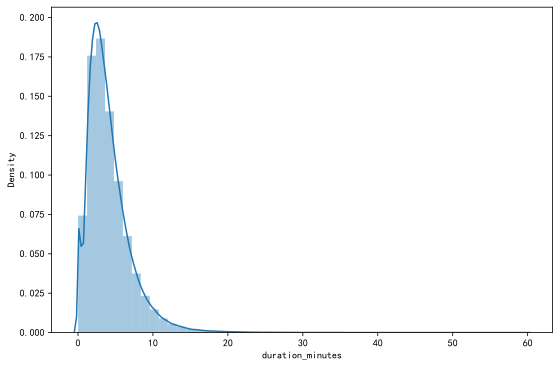

In [23]:
# 画出小于60分钟的订单时长的分布
plt.figure(figsize=(9, 6))
duration_minutes = df_didi["duration_minutes"]
duration_minutes = duration_minutes.loc[duration_minutes < 60]
sns.distplot(duration_minutes)

# 分析：这里有一个insight，可以看到很多的订单的时间都非常短，可能跟原始数据记录的准确与否相关。
# 也就是可能会有计量所说的叫什么bias，selection bias还是什么东西，比如订单的结束时间，很多滴滴司机都会提前点击订单结束，以便于刚送到一个乘客就可以马上开始新的订单。所以很多时候数据未必准确

<Figure size 648x432 with 0 Axes>

<AxesSubplot:xlabel='weather', ylabel='duration_minutes'>

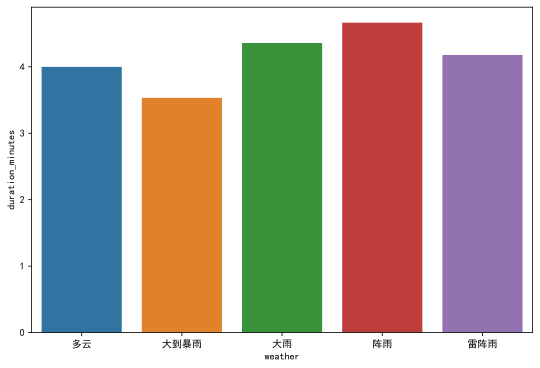

In [24]:
# 不同天气订单时间的平均值

hour_group = df_didi_combined.groupby("weather")
hour_distance = hour_group.agg({"duration_minutes": "mean"}).reset_index()
plt.figure(figsize=(9, 6))

sns.barplot(x='weather', y='duration_minutes', data=hour_distance)

空间特征分析

In [26]:
# 订单距离统计量
df_didi["start_end_distance"].describe()

# 可以看出距离的平均值为4公里左右

count    1.548464e+06
mean     4.065521e+03
std      2.315363e+03
min      0.000000e+00
25%      2.350852e+03
50%      3.670840e+03
75%      5.294258e+03
max      2.103707e+04
Name: start_end_distance, dtype: float64

<Figure size 648x432 with 0 Axes>

<AxesSubplot:xlabel='start_end_distance', ylabel='Density'>

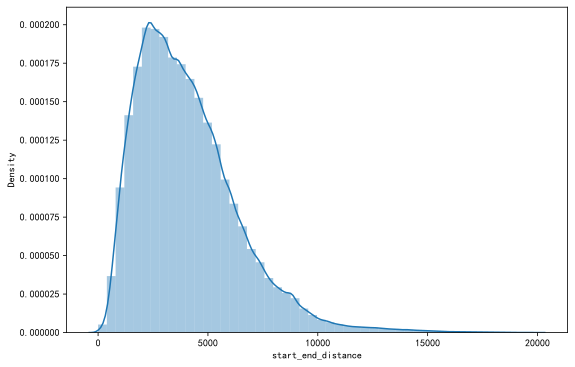

In [27]:
# 画出小于20公里的订单距离的分布
plt.figure(figsize=(9, 6))
start_end_distance = df_didi["start_end_distance"]
start_end_distance = start_end_distance.loc[start_end_distance < 20000]
sns.distplot(start_end_distance)

<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='hour', ylabel='start_end_distance'>

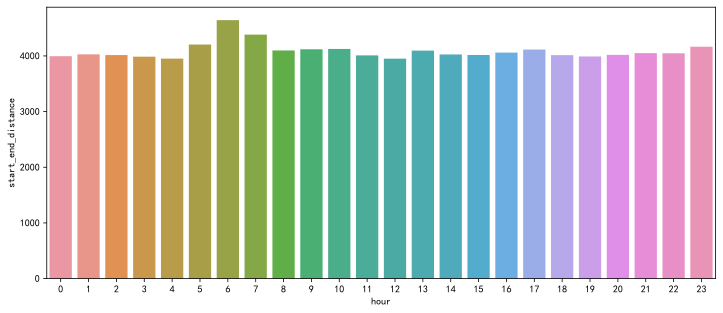

In [29]:
# 接下来来看不同的时间段是否会影响用户的打车距离
hour_group = df_didi.groupby("hour")
hour_distance = hour_group.agg({"start_end_distance": "mean"}).reset_index()
plt.figure(figsize=(12, 5))
sns.barplot(x='hour', y='start_end_distance', data=hour_distance)

# 分析：这里可以看到不同时间段对用户的打车距离影响也不大。早上6-7点打车距离较长也许是因为要打车去机场所致。因此接下来可以进一步分析这类订单的终点是否在机场附近的比例更高，留给大家探索

<Figure size 864x360 with 0 Axes>

<AxesSubplot:xlabel='weather', ylabel='start_end_distance'>

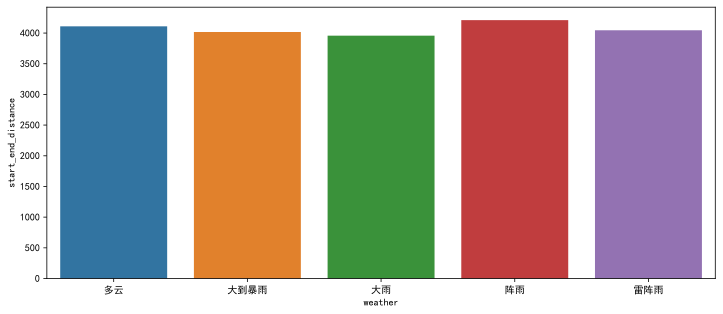

In [30]:
# 还可以分析不同的天气状态下的平均行驶距离

hour_group = df_didi_combined.groupby("weather")
hour_distance = hour_group.agg({"start_end_distance": "mean"}).reset_index()
plt.figure(figsize=(12, 5))

sns.barplot(x='weather', y='start_end_distance', data=hour_distance)

# 分析：符合直觉，与行驶时间不同，大到暴雨天气下的平均行驶距离没有明显更小

绘制起点终点地理位置的二维histogram

In [31]:
# 仍然是随机取10000个点绘图
start_points = []
start_lng = df_didi['starting_lng']
start_lat = df_didi['starting_lat']
# 每一个point为（纬度、经度、权重），这里每个点权重都设为1
start_points = [[i[1], i[0], 1] for i in np.random.permutation(list(zip(start_lng, start_lat)))[:10000]]

end_points = []
end_lng = df_didi['dest_lng']
end_lat = df_didi['dest_lat']
# 每一个point为（纬度、经度、权重），这里每个点权重都设为1
end_points = [[i[1], i[0], 1] for i in np.random.permutation(list(zip(end_lng, end_lat)))[:10000]]

# 热力图渲染
map_start = folium.Map(location=[20.0, 110.3],  # 设置地图显示的中心点
                       zoom_start=12,  # 地图默认加载时的缩放等级
                       tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=7&x={x}&y={y}&z={z}',
                       attr='default')
HeatMap(start_points).add_to(map_start)
map_start.save("./output/didi_start_heatmap.html")

map_end = folium.Map(location=[20.0, 110.3],  # 设置地图显示的中心点
                     zoom_start=12,  # 地图默认加载时的缩放等级
                     tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=7&x={x}&y={y}&z={z}',
                     attr='default')
HeatMap(end_points).add_to(map_end)
map_end.save("./output/didi_end_heatmap.html")